### An introduction to how machine learning can help us analyze millions of solar spectra efficiently  
#### Notebook 1. Clustering 
*by Brandon Panos*$^{1,2}$  

1 *University of Applied Sciences and Arts Northwestern Switzerland, Bahnhofstrasse 6, 5210 Windisch, Switzerland*  
2 *University of Geneva, CUI-SIP, 1205 Geneva, Switzerland*

**----------------------------------------------------------------------------------------------------------------------------**  

### The k-means algorithm
First conceived by <font color='dodgerblue'>J. MacQueen, 1967</font>, It is one of the most used and successful clustering algorithms of all time. The original publication has accreted 30977 citations!  

<img src="pics/k_means_results3.png" width="1000">  

The above panel shows real results using the k-means clustering algorithm. k-means allows us to automatically observe the types of emission during several different solar flare, allowing us to quickly and efficiently analyze flare behavior. Details in the paper: <font color='dodgerblue'>B. Panos et al (ApJ. 2018, 861, 62)</font> 

In [1]:
import pickle
import numpy as np
from utils import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
np.random.seed(1) # set the seed for reproducible results
# IRISreader is a python library built by Cédric Huwyler to handle large volumes of IRIS data
import irisreader as ir
ir.config.verbosity_level=0
from irisreader import observation

### The maths

The k-means algorithm of <font color='dodgerblue'> MacQueen</font> groups your data in a natural way by placing similar-looking objects within the same group. The algorithm can be thought of as a multi-dimensional dynamic histogram. In a histogram, we sacrifice accuracy for interpretability by assigning slightly different numbers into the same bin. In other words, we are happy to ignore the small details in order to perform statistics. The difference between an ordinary histogram and k-means is that k-means can bin abstract objects such as shapes instead of just simple scalar values. Let's look at the maths behind the algorithm...

The algorithm works by initiating $|\text{k}|$ centroids into the data space. A centroid is just another point with the same dimensionality as the dataset. Each data point is then assigned to the centroid they appear nearest to. The k-means objective is to 1) assign all points to their nearest centroids, and 2) find the positions of the centroids that minimize the total within-cluster distance or "inertia", given by
$$
\mathcal { L } = \sum _ { i = 1 } ^ { n } \sum _ { j = 1 } ^ { k } \delta _ { c _ { i } , j } \left\| x _ { i } - \mu _ { j } \right\| ^ { 2 },
$$
where $\mu_j$ is the $j\text{'th}$ centroid, $x_i$ the $i\text{'th}$ data point, and $\delta_{c_i,j}$ the kronecker delta defined as

$$
\delta _ { c_i , j } = \left\{ \begin{array} { l l } { 1 , } & { \text { if } x _ { i } \text { belongs to group } j } \\ { 0 , } & { \text { if } x _ { i } \text { does not belong to group } j } \end{array} \right.
$$

The k-means algorithm minimizes the objective function $\mathcal{L}$ by initiating the centroids in the locations of $|\text{k}|$ randomly selected data points, and then iterating over a two-step procedure known as coordinate descent:
1.  The data is partitioned into groups based on which centroid they appear nearest to
$$
c _ { i } = \underset { 1 \leq j \leq k } { \arg \min } \left\| x _ { i } - \mu _ { j } \right\| ^ { 2 }.
$$
2. The centroids are updated to the mean position of each group
$$
\mu _ { j } = \frac { 1 } { n _ { j } } \sum _ { i = 1 } ^ { n } \delta _ { c _ { i } , j } x _ { i }.
$$

This two-step iteration terminates when either the centroids stop updating their location, or the distance between the old and new centroid positions are all below some specified threshold. The clustering depends on the initial random placement of centroids (i.e., the problem is non-convex), hence it is customary to repeat the process a number of times and select the clustering with the lowest total inter-cluster distance (Inertia). 

### The maths in motion  
We now see how the algorithm behaves on an artificial data set. Each black point represents a single example in our dataset. We initiate four green points randomly into the data space. These points are our centroids. Each data point is first assigned to the centroid it appears closest to using the maths of **step 1**. The centroids are then shifted to the average position of their assigned group members using **step 2**. The centroids spider through the dataset until the algorithm converges, at which point, k-means has found a very natural way to partition the data into four groups. Notice how the algorithm iteratively make the sum of all the red distances (the objective function) smaller with each update. 

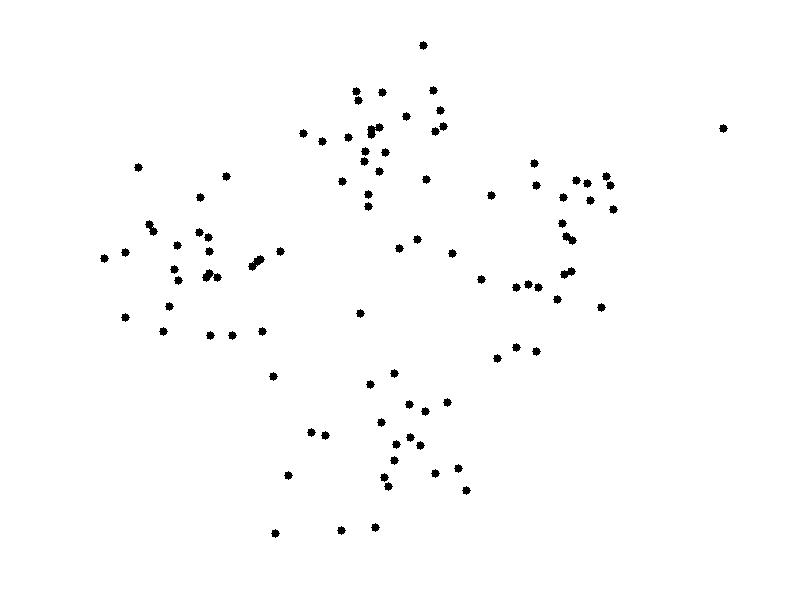

In [69]:
with open('pics/k_means.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

k-means has a time complexity that is effectively linear, making it big data scalable, however, it requires the manual selection of the number of groups $|\text{k}|$. A number of techniques have been proposed to automate the choice of $|\text{k}|$. We will explore one of the popular methods known as the elbow technique. We provide a fast mini-batch version of the k-means algorithm below, which will be used in this chapter. For the details of this version, we refer the reader to the source code https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

### The math in code  
Below is a fast working version of k-means

In [3]:
def mini_batch_k_means(X, n_clusters=10, batch_size=10, n_init=10, verbose=0):

    '''
    Return centroids and labels of a data set using the k-means algorithm in minibatch style

    input: X --> dataset
           n_clusters --> number of groups to find in the data |k|
           batch_size --> number of data points used for a single update step of the centroids
           n_init --> number of times to run k-means, the iteration with the lowest inertia is retained
           verbose --> output statistics
           
    output: centroids --> average point of each group
            labels --> list of assignments indicating which centroid each data point belongs to
            inertia --> measure of performance, the sum of all intercluster distances
    '''
    # k-means++ initiates the centroids in a smart configuration, promoting better convergence results
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                          n_init=n_init, max_no_improvement=10, verbose=verbose)

    mbk.fit(X)

    centroids = mbk.cluster_centers_
    labels = mbk.labels_
    inertia = mbk.inertia_

    return centroids, labels, inertia, n_clusters

### Finding the optimal number of groups $|\text{k}|$  

The central question for this algorithm is: how many groups should we partition our data into? For some datasets, there exists a natural number of groups that can be found by monitoring how the inertia behaves when successively increasing the group number. This method is called the **elbow technique**, and it asserts that the optimal number of groups is given by the point where the inertia drastically decreases and then subsequently undergoes only a gradual improvement with each additional group. This behavior when plotted looks like a elbow and is where the technique derives its name. Although such a technique is useful for some datasets, it fails for others. We will demonstrate this with two synthetic datasets and then apply the same technique on a real dataset containing spectra from the quiet Sun (QS) and flares (FL), before comparing the results.  

In [4]:
# generate two sample data sets, X1 and X2 consisting of 3000 data points living in two-dimensions
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]]
X1, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.2)
X2, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=10)

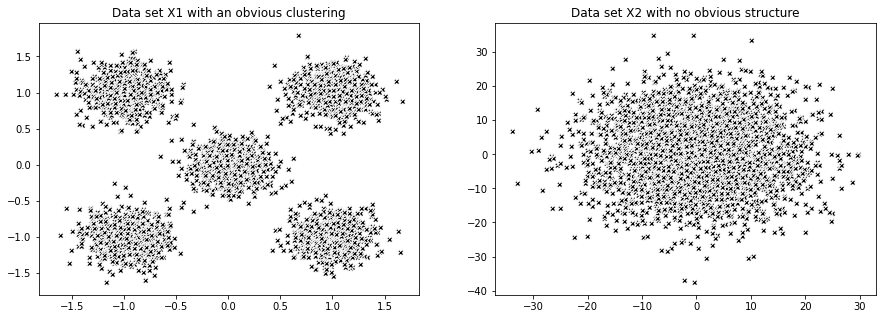

In [5]:
# plot both data sets
fig = plt.figure( figsize=(15,5) )
ax1=plt.subplot(121)
ax1.plot(X1[:, 0], X1[:, 1], 'w', markerfacecolor='k', marker='X')
plt.title('Data set X1 with an obvious clustering')
ax2=plt.subplot(122)
ax2.plot(X2[:, 0], X2[:, 1], 'w', markerfacecolor='k', marker='X')
plt.title('Data set X2 with no obvious structure')
plt.show()

In [6]:
# run k-means and collect lists of both datasets inertia for successive increases in group number
X1_list_of_inertias = []
for n_groups in range(10):
    centroids, labels, inertia, n_clusters = mini_batch_k_means( X1, n_clusters=n_groups+1 )
    X1_list_of_inertias.append( inertia )
    
X2_list_of_inertias = []
for n_groups in range(10):
    centroids, labels, inertia, n_clusters = mini_batch_k_means( X2, n_clusters=n_groups+1 )
    X2_list_of_inertias.append( inertia )

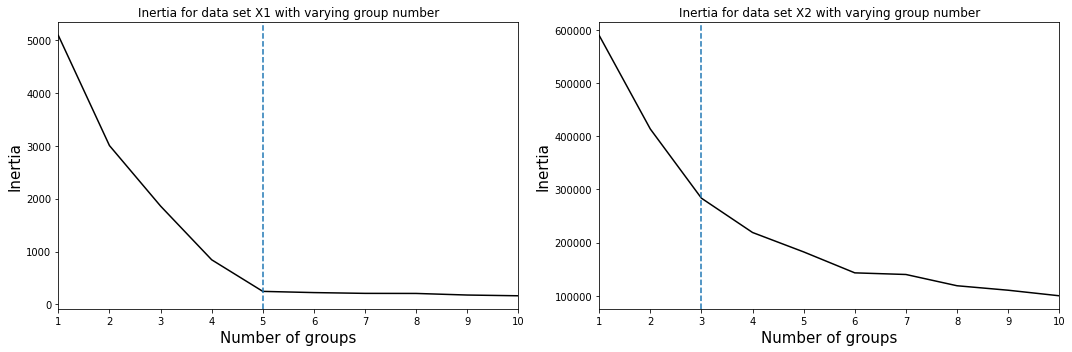

In [7]:
# plot inertia vs. group number for each dataset
fig  = plt.figure( figsize=(15,5) )

ax1=plt.subplot(121)
ax1.plot( np.linspace(1,10,len(X1_list_of_inertias)), X1_list_of_inertias, color='k' )
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.axvline(x=5, linestyle='--')
ax1.margins(x=0)
plt.ylabel('Inertia', size=15)
plt.xlabel('Number of groups', size=15)
plt.title('Inertia for data set X1 with varying group number')

ax2=plt.subplot(122)
ax2.plot( np.linspace(1,10,len(X2_list_of_inertias)), X2_list_of_inertias, color='k' )
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
ax2.axvline(x=3, linestyle='--')
ax2.margins(x=0)
plt.ylabel('Inertia', size=15)
plt.xlabel('Number of groups', size=15)
plt.title('Inertia for data set X2 with varying group number')

plt.tight_layout()
plt.show()

A clear shoulder appears for dataset X1, suggesting a natural choice for the number of groups as five. On the other hand, data set X2 has a less distinguishable shoulder, and hence no clear group number. The shoulder technique recommends five groups so let's now initiate the k-means algorithm with five centroids and see if the results are reasonable. 

In [8]:
# plotting function to visualize the results of k-means
def plot_kmeans_results( X, labels, n_clusters, ax=None, **kwargs ): 
    ax = ax or plt.gca()
    colors = ['#FF9C34', 'black', 'gold', 'aquamarine', '#4EACC5', 
              '#FF9C34', '#4E9A06', 'pink', 'blue', 'grey', 'red']
    for k, clr in zip(range(n_clusters), colors):
        my_members = labels == k
        ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=clr, marker='X')
    ax.set_title('K-means results') 
    plt.grid(False)
    return None

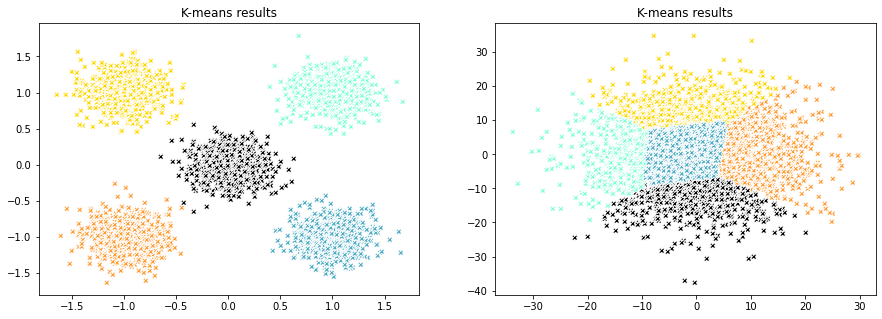

In [9]:
# use k-means with |k| = 5 for data set X1 and X2
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
centroids, labels, inertia, n_clusters = mini_batch_k_means( X1, n_clusters=5 )
plot_kmeans_results(X1, labels, n_clusters, ax1)
centroids, labels, inertia, n_clusters = mini_batch_k_means( X2, n_clusters=5 )
plot_kmeans_results(X2, labels, n_clusters, ax2)
plt.show()

The first dataset is perfectly and intuitively organized by the algorithm, however, the results for the second dataset are more ambiguous, and it is not certain if this partitioning of the data is optimal or not. We will now look at real spectral data from IRIS and try to identify whether we are dealing with a dataset like that on the left or like the blob dataset on the right.

### Real data  
We will import some data that was taken by NASA's Interface Region Imaging Spectrograph (IRIS) small explorer spacecraft (<font color='dodgerblue'>De Pontieu et al. 2014</font>).
<img src="pics/IRIS_SDO.png" width="1000">  
This image was taken from the cover of the journal **Science** 17 October 2014. The IRIS satellite sees the boxed region and has a spectrometer (seen here as a black slit) that collects light from different atomic transitions. This light is called spectra and forms the principal data type that we study.  

We will use the capabilities of IRISreader to show the observation details of our flare, including the GOES X-ray flux, a video of the event, and some details about the shape of the data

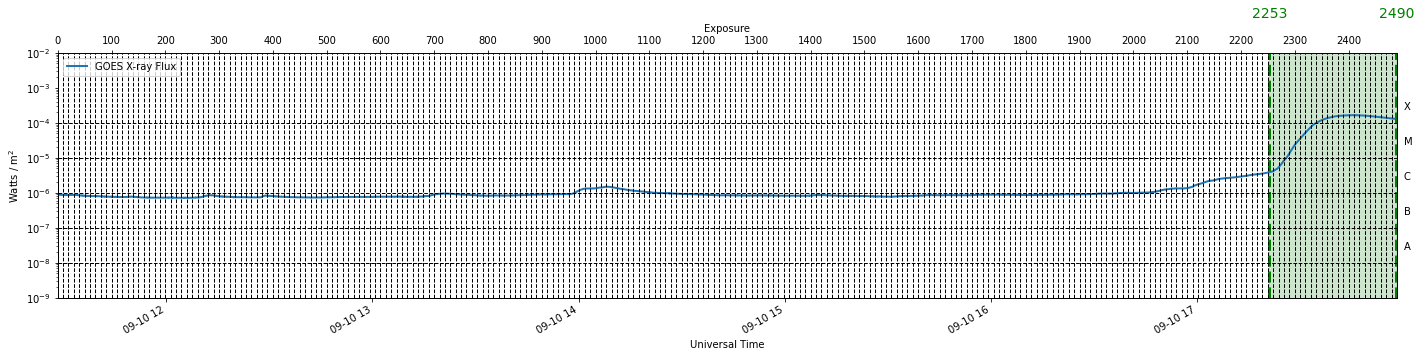

Cutting raster from indices 2253-2489 --> 36.9 minutes (of 59.0 minutes total flare duration)


Raster is 36.9 minutes long after cut
data Shape: (1, 237, 776, 240), raster shape: (237, 776, 626), n_raster_pos: 1


In [11]:
# Define the wavelength window for the Mg II h&k line that we want to extract
n_bins = 240
core_1 = 2796.34
core_2 = 2803.52
lambda_min = 2794.14
lambda_max = 2805.72
xax = np.linspace( lambda_min, lambda_max, n_bins )

# Use IRISreader to show observation details
fl_obs = observation('data/iris_obs', keep_null=True)
fl_data, fl_raster, fl_sji = extract_flare( fl_obs, lambda_min, lambda_max, n_bins, verbosity_level=2 )

### Lets import the spectral data corresponding to this flare and  a quiet Sun observation
1. Mg II spectra collected from a solar flare (FL) <font color='coral'>FL_20140910_112825_3860259453</font>
2. Mg II spectra from the quiet Sun (QS) <font color='dodgerblue'>QS_20151010_233413_3620005935</font>    

The spectra for the flare dataset is stored in a numpy array called <font color='coral'>fl_spectra</font>. Each row is a different spectra of length 240. Similarly, the quiet Sun dataset is stored in a numpy array called <font color='dodgerblue'>qs_spectra</font>. Each spectrum can be described in terms of several features found in the variables <font color='coral'>fl_features</font> and <font color='dodgerblue'>qs_features</font>.

In [8]:
# Load quiet Sun dataset
with open('data/qs_spectra.p', 'rb') as f: qs_spectra = pickle.load(f)
with open('data/qs_features.p', 'rb') as f: qs_features = pickle.load(f)
# Load flare dataset
with open('data/fl_spectra.p', 'rb') as f: fl_spectra = pickle.load(f)
with open('data/fl_features.p', 'rb') as f: fl_features = pickle.load(f) 

Use the  <font color='green'>spectra_quick_look_gen</font> helper function from utils to glance at a sample of the <font color='coral'>flare</font> dataset

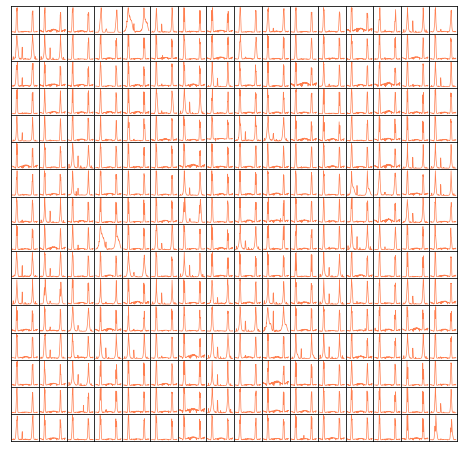

In [9]:
spectra_quick_look_gen( fl_spectra, clr='coral', dim=16)

Lets zoom into one of the <font color='coral'>flare</font> spectra, spectra 154570, and print out this spectrums features

In [10]:
spec = fl_spectra[154570] # select a single flare spectrum
for feature, value in fl_features.items(): # print out its associated features
    print(feature + ': ' + str(np.round(value[154570],2)))

intensity: 1042.35
triplet_intensity: 322.13
line_width: 16.0
line_asymmetry: 0.5
total_continium: 4.7
kh_ratio: 1.2


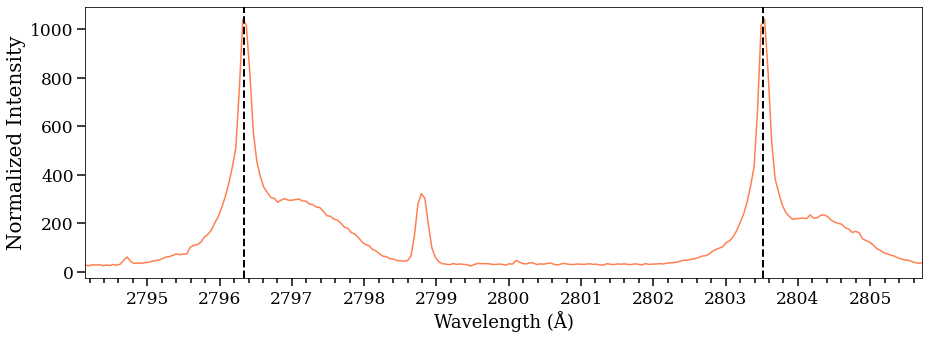

In [13]:
# Plot flare spectrum 154570
fig, ax = plt.subplots(figsize=(15,5))
plt.ylabel('Normalized Intensity',fontsize=20)
plt.xlabel('Wavelength (Å)', fontsize=18)
plt.plot(xax, spec, c='coral')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(.2))
ax.tick_params(which='major', length=8,width=1.5) 
ax.tick_params(which='minor', length=5,width=1.5)
plt.axvline(x=core_1, c='k', linestyle='--', linewidth=2)
plt.axvline(x=core_2, c='k', linestyle='--', linewidth=2)
plt.xlim(xax[0],xax[-1])
plt.show()

<img src="pics/features.png" width="1000">

The image above shows what each of the six features measure. This will become important in other notebooks.

## ! Exercises

Before trying to find the optimal group number |k|, lets see what happens when we blindly apply the k-means algorithm to our IRIS spectral data 

In [46]:
'''
Q1) Run the k-means algorithm on the flare spectra using the function mini_batch_k_means with n_clusters=50
'''

### CODE HERE 

n_groups = 50

centroids, ..

### CODE HERE

In [63]:
'''
Q2) Plot the centroids you have found using the helper function below
'''

centroid_summary( centroids, rows=10, cols=5 )

In [65]:
'''
Q3) Do you notice that some centroids look very similar? 
The reason for this is that they have the same shape but different intensities.
Since the intensities can vary over orders of magnitude, we are waisting many centroids trying to cover this parameter
Lets get rid of the intensity variable by normalize the centroids

Normalize each flare spectra by its maximum value using numpy in one line. Return a matrix of the same dimensions
''' 


### CODE HERE 

fl_spectra_norm =

qs_spectra_norm =

### CODE HERE 

In [66]:
'''
Q4) Run the k-means algorithm again but this time with the normalized flare spectra
'''

### CODE HERE 


### CODE HERE 

Notice that we should now see a richer variety of spectral shapes. This becomes more obvious with larger data sets. Normalization is an essential step! 

### Finding the optimal number of groups $|\text{k}|$ for IRIS spectra

In [40]:
'''
Q5) Repeat the elbow analysis from In [6] on the normalized flare and quiet Sun datasets
Note: If the algorithm is taking to long to converge, interrupt the kernel by clicking in this cell and then 
pressing the stop (square) symbol at the top of the page
You should then change the batch_size, and or n_init
'''

### CODE HERE 

fl_list_of_inertias = []
for n_groups in range(10):
    
qs_list_of_inertias = []
for n_groups in range(10):

### CODE HERE 

In [67]:
'''
Plot inertia vs. group number for both the QS and FL dataset by running this cell
So long as you used the given variables this should run without adjustments
'''

fig  = plt.figure( figsize=(15,5) )

ax1=plt.subplot(121)
ax1.plot( np.linspace(1,10,len(fl_list_of_inertias)), fl_list_of_inertias/max(fl_list_of_inertias), color='coral', label='Flare data')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.margins(x=0)
plt.ylabel('Inertia', size=15)
plt.xlabel('Number of groups', size=15)
plt.title('Inertia for flare dataset with varying group number', size=12)
plt.axvline(x=5, linestyle='--', c='k')
plt.plot( np.linspace(1,10,len(X1_list_of_inertias)), X1_list_of_inertias/max(X1_list_of_inertias), color='k', linestyle='--', label='Structured data')
plt.plot( np.linspace(1,10,len(X2_list_of_inertias)), X2_list_of_inertias/max(X2_list_of_inertias), color='k', linestyle=':', label='Blob data')
plt.legend()

ax2=plt.subplot(122)
ax2.plot( np.linspace(1,10,len(qs_list_of_inertias)), qs_list_of_inertias/max(qs_list_of_inertias), color='dodgerblue', label='Quiet Sun data')
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
ax2.margins(x=0)
plt.ylabel('Inertia', size=15)
plt.xlabel('Number of groups', size=15)
plt.title('Inertia for quiet dataset with varying group number', size=12)
plt.axvline(x=3, linestyle='--', c='k')
plt.plot( np.linspace(1,10,len(X1_list_of_inertias)), X1_list_of_inertias/max(X1_list_of_inertias), color='k', linestyle='--', label='Structured data')
plt.plot( np.linspace(1,10,len(X2_list_of_inertias)), X2_list_of_inertias/max(X2_list_of_inertias), color='k', linestyle=':', label='Blob data')
plt.legend()

plt.tight_layout()
plt.show()

Our real-life spectral data resembles a structureless dataset similar to that of the artificial X2 dataset (dotted line). It is often the case, and spectral analysis with IRIS is no exception, that the selection of the number of groups to use in k-means can not be automated, and should be left to the discretion of a professional in the field.

In [55]:
'''
Since it is uncertain what the optimal number of centroids is, we will start by using 50 centroids
Run the following code blocks
'''
n_groups = 50
centroids, labels, inertia, n_clusters = mini_batch_k_means(fl_spectra_norm, n_clusters=n_groups, batch_size=1000, n_init=20)

Make use of the <font color='green'>centroid_summary</font> function in utils to visualize the results

In [68]:
centroid_summary( centroids, rows=10, cols=5 )

In [61]:
'''
Q6) Each centroid represents the average of a group. 
Your task now is to plot the centroid and overplot all of its group members
Remember 

Find all the spectra that have been assigned to this centroid  
Hint: the indices where the label variable from k-means is the same as your chosen cent_ind
'''

### CODE HERE 

# select a centroid from the above plot
cent_ind = 

### CODE HERE

## ! End of exercises

## Demo  
We demonstrate here how useful this type of transformation can be when analyzing complex data. If you have downloaded the full flare observation you can run the following blocks. We can use k-means to discretize our continuous spectral data and automatically see what types of emission are generated at specific locations on the Sun during a flare.

Load centroids from the study of <font color='dodgerblue'>B. Panos et al (ApJ. 2018, 861, 62)</font> using IRISreader 

In [58]:
from irisreader.data import mg2k_centroids
centroids = mg2k_centroids.get_mg2k_centroids()

plot centroids and create a color dictionary for the masked animations 

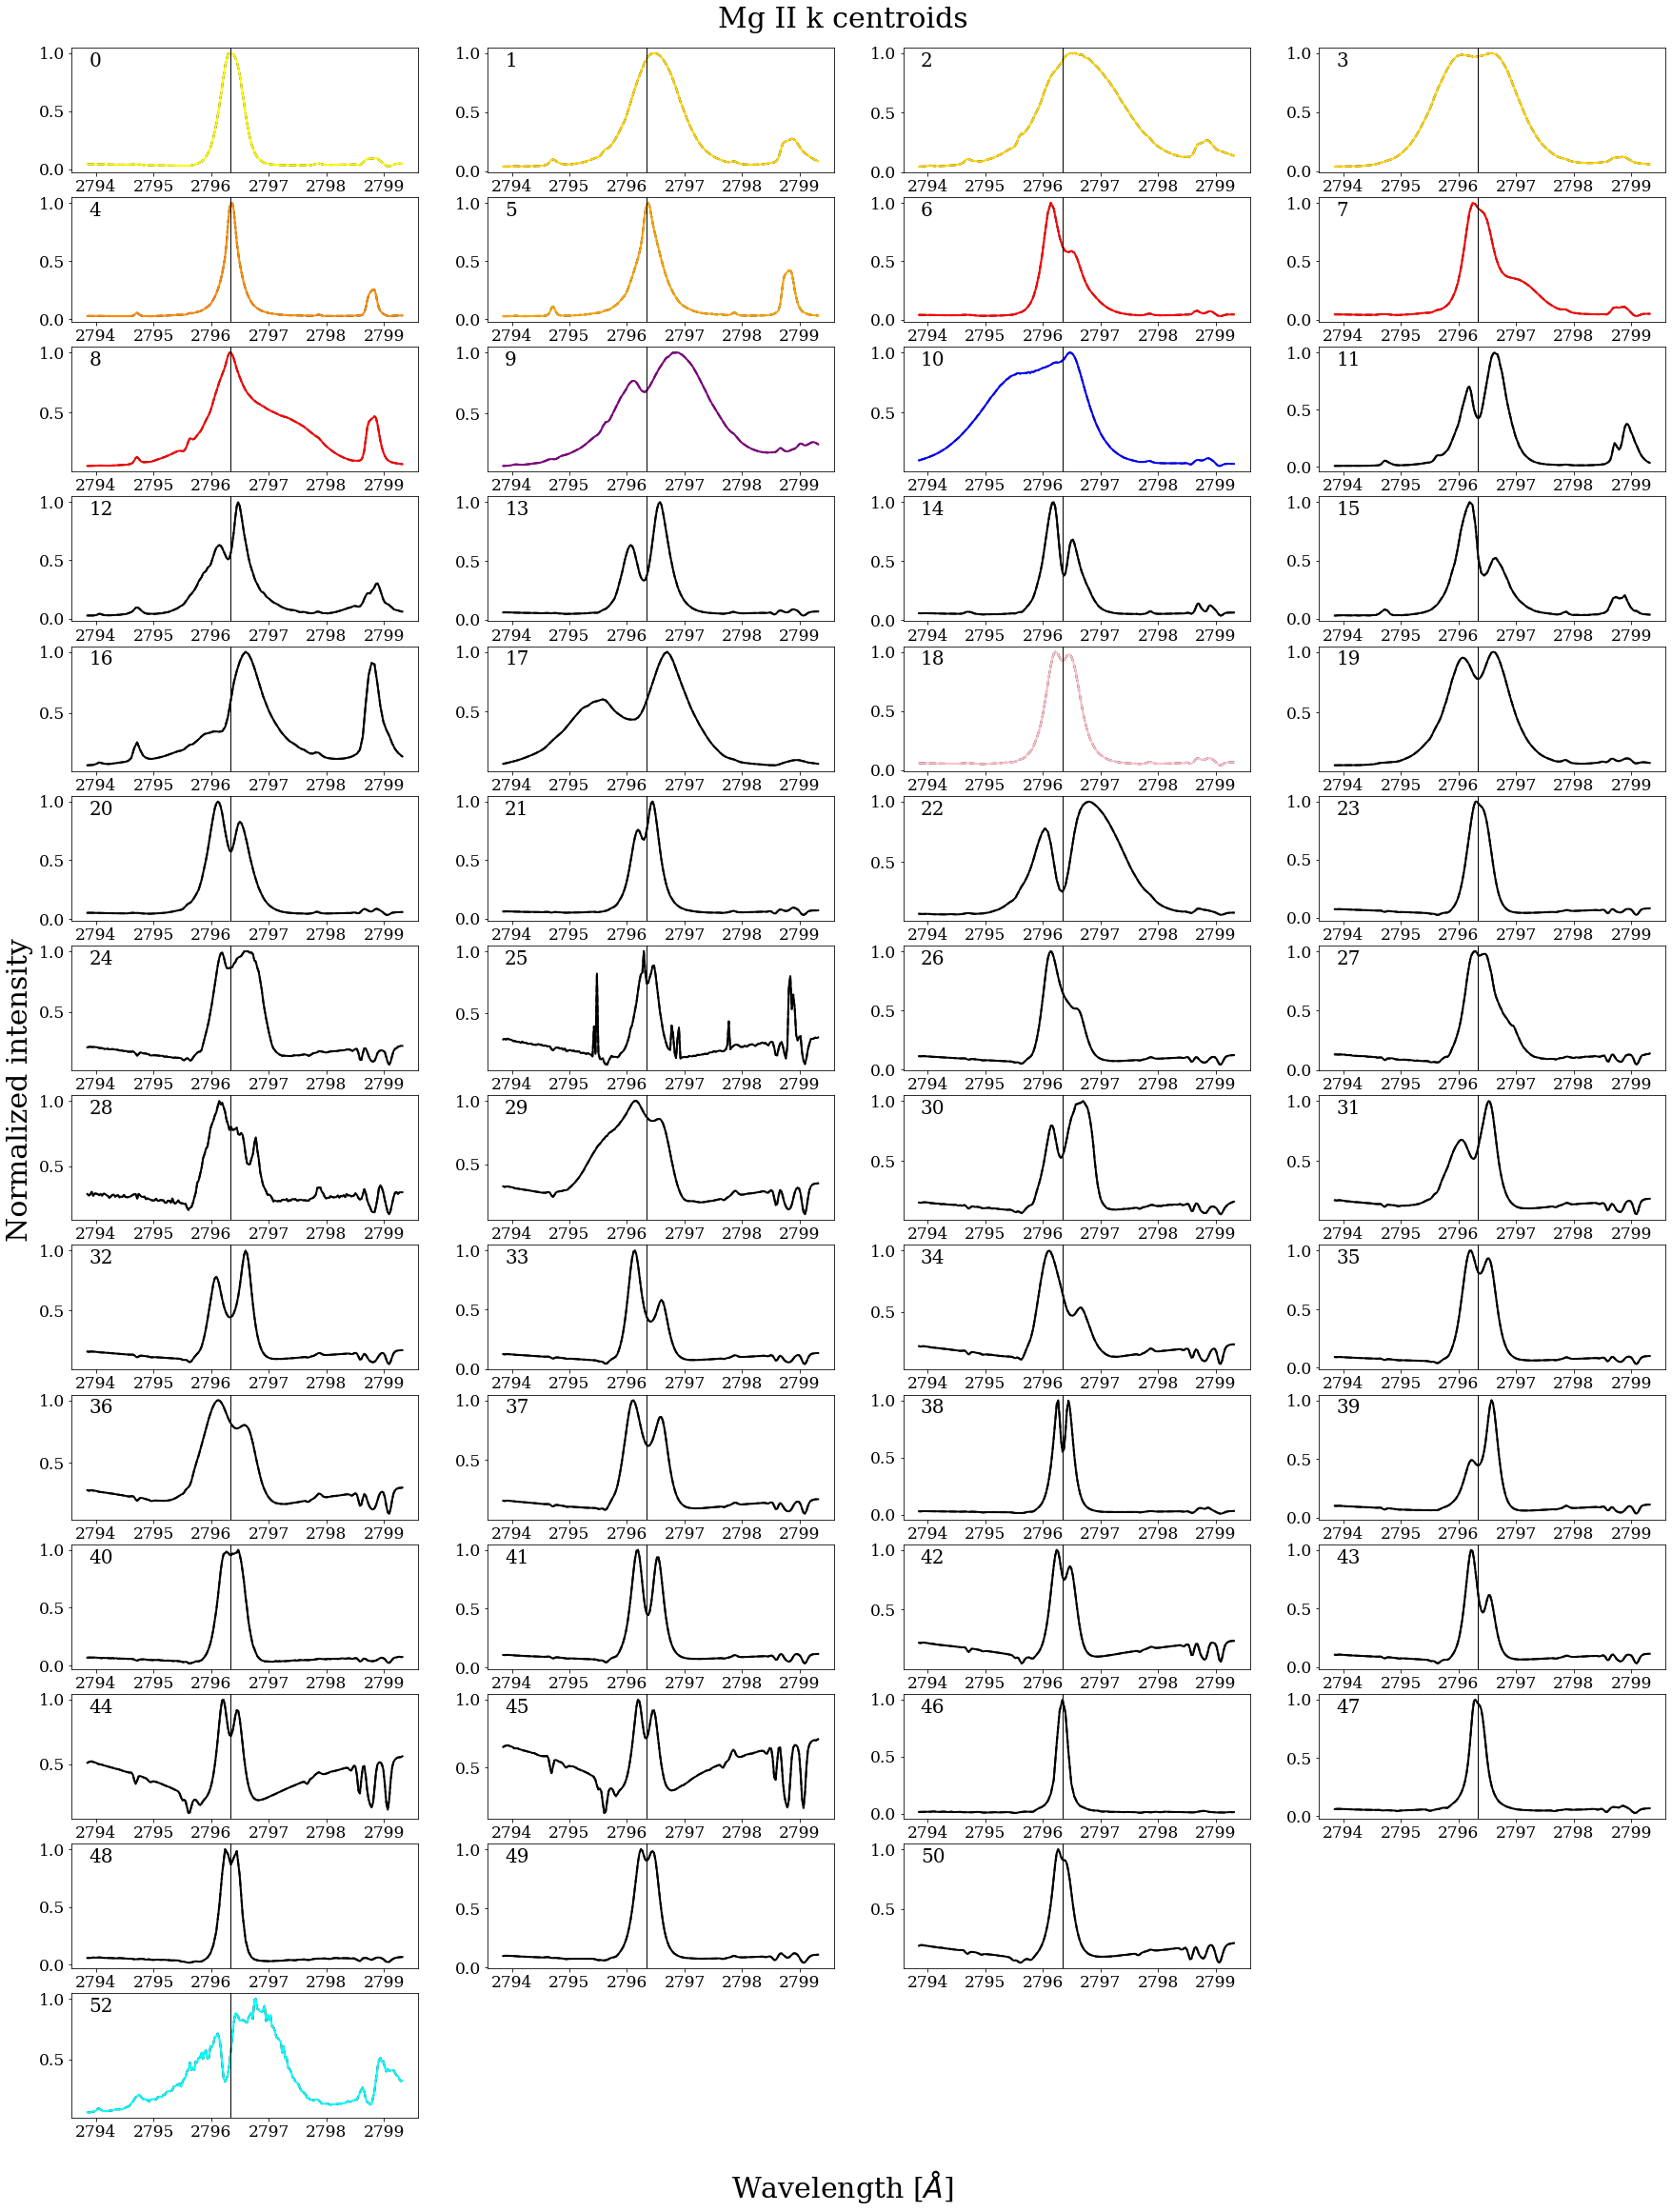

In [59]:
lambda_min = 2793.85
lambda_max = 2799.32
n_bins = 216 # number of wavelength points to interpolate onto 
line_core = 2796.34 # location of the Mg II k-line core 
nprofxax = np.linspace( lambda_min, lambda_max, n_bins ) # new wavelength x-axis for plotting results 
rows = 14
cols = 4
in_text = 20

grps = [0,1,2,3,4,
        5,6,7,8,9,
        10,11,12,18,
        52]
clrs = ['yellow','gold','gold','gold','darkorange',
        'orange','red','red','red','purple',
        'blue','black','black','pink',
        'cyan']
clr_dic = dict(zip(grps, clrs))

fig, axs = plt.subplots(rows, cols, figsize = (30, 40) )
ax=axs.ravel()
for k in range(len(centroids)):
    if k == 51: continue # dont plot the bad profiles belonging to group 51
    ax[k].plot(nprofxax, centroids[k], color='black', linewidth=2, linestyle='--')
    ax[k].plot(nprofxax, centroids[k], color=clr_dic.get(k,'black'), linewidth=2)
    ax[k].axvline(x=line_core,color='black',linewidth = 1)
    ax[k].text( .05, .85, str(k), transform=ax[k].transAxes, size=in_text)
    
ax[51].axis('off')
ax[53].axis('off')
ax[54].axis('off')
ax[55].axis('off')
    
fig.text(0.5, 0.89, 'Mg II k centroids', ha='center', va='center', rotation='horizontal',size=30)
fig.text(0.5, 0.1, 'Wavelength [$\AA$]', ha='center', va='center', rotation='horizontal',size=30)
fig.text(0.1, 0.5, 'Normalized intensity', ha='center', va='center', rotation='vertical',size=30)
plt.show()

In [60]:
# animate the SJI's of the flare observation
fl_obs = observation("data/iris_obs", keep_null=True)
animate_mask(fl_obs, 'f1', centroids, clr_dic)

The colors in the video correspond to the colors in the centroid plot. If a particular color appears in the video, it indicates that the emission in the Mg II spectral line is most similar to the centroid with the same color. These particular centroids were derived from many flare observations and took lots of manual input. The question of whether there is an optimal number of centroids |k| is still open.  

<!-- <img src="../pics/data_qs_fl.png" width="1000"> -->

<!-- The two panels on the right of the above image show a subsample of 256 <font color='coral'>flare</font> and <font color='dodgerblue'>quiet Sun</font> spectra. Lets zoom into one of the <font color='coral'>flare</font> spectra, spectra 154570  -->

### Can we just look at our data to decide the optimal number of centroids? $\to$ see **dimensionality reduction**

This will be the topic of our next notebook and falls under the heading of **dimensionality reduction**, which is a host of algorithms that try to faithfully represent high-dimensional data within the confines of three or fewer dimensions to aid visualization. Since it was easy to identify from visual inspection that 5 groups was optimal for our synthetic X1 dataset, perhaps it will also be obvious if we can somehow look at our IRIS data. 